In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='begin'></a>
# Оглавление

- ### [Техническое задание](#task)
    - [Выбор технических метрик качества](#metrics)
    - [Информация](#information)
    - [Датасеты](#datasets)
    
- ### [Изучение данных](#search)
    - [Анализ данных](#analysis)
    - [Предобработка: временные признаки и типы данных](#preprocessing)
    - [Анализ временного ряда датасета events](#analysis_time)
    - [Дополнительная проверка: Частота](#analysis_time_bonus)
    - [Анализ свойств товаров](#analysis_items)
    - [Сохранение: Dataset df_events](#save_events)
    
- ### [Создание факторов для модели](#create_factors)
    - [Dataset: df_temp](#preprocessing_rating)
    - [Сохранение: Dataset df_temp](#save_temp)
    
- ### [Дополнительные признаки: df_all_features](#xgboost_preprocessing)
    - [Сохранение: Dataset df_all_features_light](#save_all_features_light)
    - [Сохранение: Dataset df_all_features](#save_all_features)

<a id='task'></a>
# Техническое задание
</br>
<b>Цель:</b> Повысить прибыль от дополнительных продаж в инетрнет-магазине на 20%.
</br>
</br>
<b>Ожидаемый результат:</b> Сервис, выдающий рекомендации по идентификатору пользователя.
</br>
</br>
<b>Технические задачи:</b> 
<ul>
    <li>Анализ данных</li>
    <li>Предобработка данных</li>
    <li>Создание факторов</li>
    <li>Автоматизация предобработки и создания факторов</li>
</ul>
</br>
<b>Полученные данные:</b> 
<ul>
    <li>events — датасет событий взаймодействия между пользователем и товаром.</li>
    <li>category_tree — датасет с деревом категорий.</li>
    <li>item_properties — датасет со свойствами товаров.</li>
</ul>
</br>
<b>Возможные риски и решения:</b>
</br>
<ul>
    <li>Несоответствующие рекомендации пользователю. <i><b>Решение:</b></i> Введение MAP@K метрики.</li>
    <li>Рекомендации новым пользователям. <i><b>Решение:</b></i> Создание стратегии холодного старта.</li>
    <li>Мало информации о пользователе. <i><b>Решение:</b></i> Рекомендации голосованием большинства по категориям товаров.</li>
</ul>

<a id='metrics'></a>
## Выбор технических метрик качества
</br>
- Платформа, на которой развернуть интрнет магазин, ограничена в показе дополнительных товаров - 3 позиции максимум. 
</br>
Заказчик заинтересован только в продажах, значит будем использовать метрику ранжирования, посчитанной на Top-K записях:
</br><i><b>MAP@K</b></i> (Mean Average Precision at K)
$$\text{MAP@K} = \frac{1}{M} \sum_{j=1}^{M} \frac{1}{r} \sum_{k=1}^{K} \text{Precision@k} \cdot rel(k)$$
</br>
</br>
- Для проверки качества предсказаний мы будем использовать метрику 
</br><i><b>RMSE</b></i> (Root Mean Squared Error)
$$\text{RMSE} = \sqrt{\dfrac {1}{|\hat{R}|}\sum_{\hat{r}_{ui} \in \hat{R}}(\hat{r}_{ui} - \mu_i)^2}$$

<a id='information'></a>
## Информация

#### events — датасет событий взаймодействия между пользователем и товаром. Колонки:

- timestamp — время события
- visitorid — идентификатор пользователя
- event — тип события
- itemid — идентификатор объекта
- transactionid — идентификатор транзакции, если она проходила
</br>
</br>
#### category_tree — датасет с деревом категорий.

- category_id — идентификатор категорий
- parent_id — идентификатор родительской категории
</br>
</br>
#### item_properties — датасет со свойствами товаров.

- timestamp — момент записи значения свойства
- item_id — идентификатор объекта
- property — свойство, кажется, они все, кроме категории, захешированы
- value — значение свойства

<a id='datasets'></a>
## Датасеты

In [2]:
events = pd.read_csv('1 events.csv')
category_tree = pd.read_csv('2 category_tree.csv')
item_1 = pd.read_csv('3 item_properties_part1.csv')
item_2 = pd.read_csv('4 item_properties_part2.csv')

<a id='search'></a>
# Изучение данных

### - Проверка имеющихся признаков датасетов:
- Тип данных столбца
- Кол-во уникальных значений
- Кол-во пустых значений
- Процент пустых значений

In [3]:
def df_info(df):
    df_info = pd.DataFrame(df.dtypes).T.rename(index = {0 : 'Column type'})
    
    try:
        df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms').dt.date
    except:
        pass
        
    temp_dict = {}
    temp_min = {}
    temp_max = {}
    for col in df.columns:
        temp_dict[col] = len(df[col].unique())
        temp_min[col] = df[col].min()
        temp_max[col] = df[col].max()
    df_info = pd.concat([df_info, pd.DataFrame(pd.Series(temp_dict)
                                                      ).T.rename(index = {0 : 'Unique values'})])
    df_info = pd.concat([df_info, pd.DataFrame(df.isnull().sum()
                                                      ).T.rename(index = {0 : 'Null values'})])
    df_info = pd.concat([df_info, pd.DataFrame(round(df.isnull().sum() / df.shape[0]*100)
                                                      ).T.rename(index = {0 : 'Null values %'})])
    df_info = pd.concat([df_info, pd.DataFrame(pd.Series(temp_min)
                                                      ).T.rename(index = {0 : 'Min value'})])
    df_info = pd.concat([df_info, pd.DataFrame(pd.Series(temp_max)
                                                      ).T.rename(index = {0 : 'Max value'})])
    #len(events), str((pd.to_datetime(events['timestamp'], unit = 'ms').dt.date).min())
    display(df_info)


#df_list = [events, category_tree, item_1, item_2]
#df_name = ['events', 'category_tree', 'item_1', 'item_2']

df_list = [events, category_tree]
df_name = ['events', 'category_tree']

for index, df in enumerate(df_list):
    print(df_name[index])
    df_info(df)
    print()

events


,timestamp,visitorid,event,itemid,transactionid,datetime
Column type,int64,int64,object,int64,float64,NaN
Unique values,2750455,1407580,3,235061,17673,139.0
Null values,0,0,0,0,2733644,0.0
Null values %,0.0,0.0,0.0,0.0,99.0,0.0
Min value,1430622004384,0,addtocart,3,0.0,2015-05-03
Max value,1442545187788,1407579,view,466867,17671.0,2015-09-18



category_tree


,categoryid,parentid
Column type,int64,float64
Unique values,1669,363
Null values,0,25
Null values %,0.0,1.0
Min value,0.0,8.0
Max value,1698.0,1698.0


### - Проверим распределение между событием и кол-вом товаров, событием и кол-вом пользователей :

In [4]:
item_count_mean = pd.DataFrame(events.groupby('event')['itemid'].value_counts()
                                 ).rename(columns = {'itemid':'item_count'}
                                         ).reset_index().drop(columns = ['itemid']
                                                             ).groupby('event').agg('mean').T

visitor_count_mean = pd.DataFrame(events.groupby('event')['visitorid'].value_counts()
                                 ).rename(columns = {'visitorid':'visitor_count'}
                                         ).reset_index().drop(columns = ['visitorid']
                                                             ).groupby('event').agg('mean').T

temp_df = pd.concat([item_count_mean, visitor_count_mean])
display(temp_df)
del temp_df

event,addtocart,transaction,view
item_count,2.900556,1.867526,11.345319
visitor_count,1.837973,1.916290,1.897416


Мы уже наблюдаем большое отклонение в сторону просмотров => При, приблизительно, схожим распределении кол-ве пользователей, распределение кол-ва просмотров товаров имеет большой правый хвост.

### - Проверка на наличие пропусков, дублей, кол-во уникальных и т.д.

Как мы видим, большое кол-во записей не являются событием покупки (99%). Давайте более детально узнаем, какое кол-во уникальных пользователей НЕ приобретали товар.

#### Проверка уникальных пользователей и событий

In [5]:
def event_info(event):    
    all_unique = events['visitorid'].unique()
    yes_unique = events[events['event'] == event]['visitorid'].unique()
    no_unique = events['visitorid'][~events['visitorid'].isin(yes_unique)].unique()

    event_info = pd.pivot_table(pd.DataFrame(pd.Series([len(all_unique), len(yes_unique), len(no_unique)]
                                                      )).T.rename(index = {0:event}, 
                                                                  columns = {0:'all', 1:'event_yes', 2:'event_no'}), 
                                index = [event])
    event_info['yes %'] = round((event_info['event_yes']*100) / event_info['all'], 1)
    
    return event_info
    
event_info_df = pd.DataFrame(columns = ['all', 'event_no', 'event_yes'])

for event in events['event'].unique():
    event_info_df = pd.concat([event_info_df, event_info(event)])
    
event_info_df

,all,event_no,event_yes,yes %
view,1407580,3401,1404179,99.8
addtocart,1407580,1369858,37722,2.7
transaction,1407580,1395861,11719,0.8


Большое количество записей отображают просмотр товара и малый процент это факт покупки товара. 
</br> В последствие дисбаланс выборки может сказаться на качество модели, так как по неформальному условию мы считаем выборку несбалансированной, когда соотношение количества преобладающего и минорного классов составляет 10:1.
</br>
</br> Методы сокращения выборок будут представлены далее. Продолжим анализ.

#### Проверим столбец transactionid на наличие дублей

In [6]:
print('Кол-во значений в столбце event:', len(events[events['event'] == 'transaction']))
print('Кол-во значений в столбце transactionid:', len(events['transactionid'].dropna()))
print('Кол-во уникальных значений в столбце transactionid:', len(events['transactionid'].dropna().unique()))

Кол-во значений в столбце event: 22457
Кол-во значений в столбце transactionid: 22457
Кол-во уникальных значений в столбце transactionid: 17672


Обнаружены дубли в столбце transactionid. Мы их удалим.

In [7]:
transactionid_duplicate = events.duplicated()
print(f'Из {len(events)} записей удалено {len(transactionid_duplicate)} дублей.')
events = events[~transactionid_duplicate]

Из 2756101 записей удалено 2756101 дублей.


#### Сравнение уникальных событий

<Axes: >

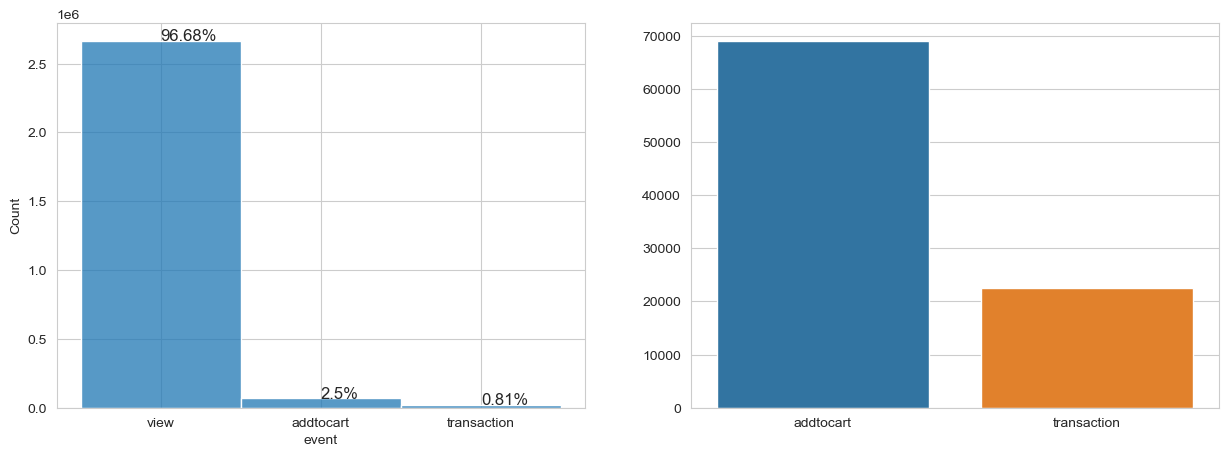

In [8]:
events_count=events['event'].value_counts()

totalcases=events.shape[0]

sns.set_style('whitegrid')
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x = 'event', data = events, bins = 3, ax = ax1)
for x, counts in zip(events['event'].unique().tolist(), events['event'].value_counts().tolist()):
    text=str(round((counts/totalcases)*100,2)) +'%'
    ax1.text(x, counts, text, fontsize=12)
    
sns.barplot(x = events['event'].unique()[1:], y = events['event'].value_counts()[1:].values, ax=ax2)

Посмотрим на самые популярные товары по событиям

Text(0.5, 1.0, 'Топ 5 проданных')

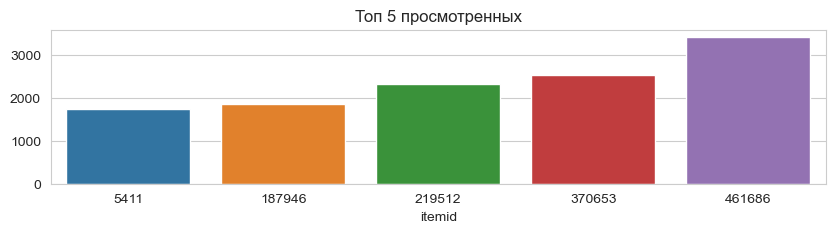

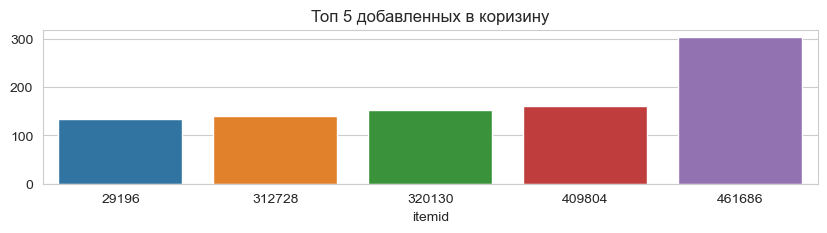

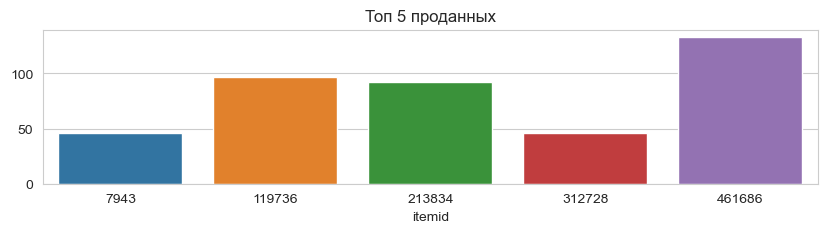

In [9]:
popular_addtocart = events[events['event'] == 'view']
popular_addtocart = popular_addtocart.groupby('itemid')['event'].value_counts().sort_values().tail(5)

idx = []
for i in popular_addtocart.index:
    idx.append(i[0])
    
popular_addtocart = pd.DataFrame(popular_addtocart)
popular_addtocart['itemid'] = idx

fig, ax = plt.subplots(figsize = (10, 2))
sns.barplot(x = popular_addtocart['itemid'].sort_values(), y = popular_addtocart['event'].values)
plt.title('Топ 5 просмотренных')


popular_addtocart = events[events['event'] == 'addtocart']
popular_addtocart = popular_addtocart.groupby('itemid')['event'].value_counts().sort_values().tail(5)

idx = []
for i in popular_addtocart.index:
    idx.append(i[0])
    
popular_addtocart = pd.DataFrame(popular_addtocart)
popular_addtocart['itemid'] = idx

fig, ax = plt.subplots(figsize = (10, 2))
sns.barplot(x = popular_addtocart['itemid'].sort_values(), y = popular_addtocart['event'].values)
plt.title('Топ 5 добавленных в коризину')



popular_transaction = events[events['event'] == 'transaction']
popular_transaction = popular_transaction.groupby('itemid')['event'].value_counts().sort_values().tail(5)

idx = []
for i in popular_transaction.index:
    idx.append(i[0])
    
popular_transaction = pd.DataFrame(popular_transaction)
popular_transaction['itemid'] = idx

fig, ax = plt.subplots(figsize = (10, 2))
sns.barplot(x = popular_transaction['itemid'], y = popular_transaction['event'].values)
plt.title('Топ 5 проданных')

Нет прямой связи между тремя событиями, кроме товара 461686. Возможное свидетельство о существование множества товаров, которые не достигли конечного события - transaction. Их чаще смотрели или добавляли в корзину, но не приобретали.

Проверим корреляцию между столбцами.

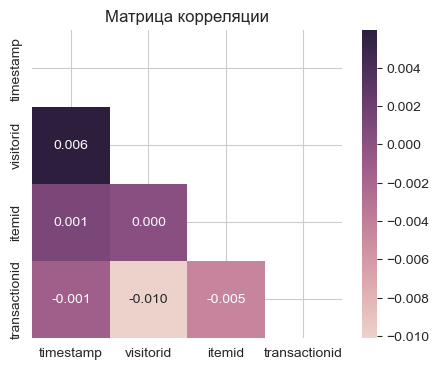

In [18]:
fig, ax = plt.subplots(figsize = (5, 4))
mask = np.triu(np.ones_like(events[events.columns].corr(), dtype=bool))
sns.heatmap(events[events.columns].corr(), annot = True, mask = mask, fmt = '.3f', cmap=sns.cubehelix_palette(as_cmap=True)).set_title('Матрица корреляции')
plt.show()

Прямой корреляции нет, но можем ли мы с полной уверенности отбросить идею, что покупка товара - это всего лишь 1 запись, а не цепь событий? 

Ведь мы имеем большой перевес по просмотрам, а наличие 3-х записей повлияет на распределение долей по категориям событий (создаст дубли приобретенного товара в двух других категориях).

### Выводы:

- События имеют большой перевес в сторону просмотров. Это вполне себе оправдано для интернет магазина. Необходимо разумно сократить кол-во данных, поскольку модели могут переобучиться.
- Наличие дублей может быть причиной отмененных заявок (не имеем данных о самих транзакций, трудно определить) или, возможная, ошибка при выгрузки данных.
- Кол-во уникальных проданных товаров - мало, правильные рекомендации помогут увеличит продажи схожих товаров.
- Прямой связи в данных не обнаружено, пока что. Дальнейшее изучение поможет выявить наличие цепи событий. 

[Вернуться к началу](#begin)

<a id='preprocessing'></a>
## Предобработка: временные признаки и типы данных

- Работа с временными признаками: Извлечение даты, года, месяца, времени, создание признака "время суток"
- OneHotEncoder: тип данных, день недели.

In [10]:
from sklearn.preprocessing import OneHotEncoder

#### Работа с временными признаками: Извлечение даты, года, месяца, времени, создание признака "время суток"

In [11]:
# Copy original dataset
df_events = events.copy()

# Transform timestamp to datetime
df_events['datetime'] = pd.to_datetime(df_events['timestamp'], unit='ms')
df_events['date'] = df_events['datetime'].dt.date
df_events['day_of_week'] = df_events['datetime'].map(lambda x: x.weekday() + 1)

df_events['year'] = df_events['datetime'].map(lambda x: x.year)
df_events['month'] = df_events['datetime'].map(lambda x: x.month)
df_events['day'] = df_events['datetime'].map(lambda x: x.day)
df_events['hour'] = df_events['datetime'].map(lambda x: x.hour)
df_events['minute'] = df_events['datetime'].map(lambda x: x.minute)

def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
df_events['day_period'] = df_events['hour'].map(get_time_periods)

#### Преобразование даты в день недели

In [12]:
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_array = encoder.fit_transform(df_events[['day_of_week']]).toarray()
feature_labels = np.array(encoder.categories_).ravel()
feature_labels = list(feature_labels)

count = 0
for i in feature_labels:
    feature_labels[count] = 'day_of_week_' + str(i)
    count+=1

encoder_df = pd.DataFrame(encoder_array, columns = feature_labels).reset_index(drop = True)
df_events = df_events.reset_index(drop = True)
df_events = df_events.join(encoder_df)

#df_events.drop(columns = ['day_of_week'], axis = 0, inplace = True)

#### Работа с временными признаками: Извлечение даты, года, месяца, времени, создание признака "время суток"

In [13]:
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_array = encoder.fit_transform(df_events[['event']]).toarray()
feature_labels = np.array(encoder.categories_).ravel()

encoder_df = pd.DataFrame(encoder_array, columns = feature_labels).reset_index(drop = True)
df_events = df_events.reset_index(drop = True)
df_events = df_events.join(encoder_df)

<a id='analysis_time'></a>
## Анализ временного ряда датасета events.

In [14]:
events_seasonal = pd.DataFrame(df_events.groupby(['date'])[['transaction', 'view', 'addtocart']].sum()).reset_index()
events_seasonal = events_seasonal.set_index(pd.DatetimeIndex(events_seasonal['date'])).drop(columns = ['date'])
events_seasonal = events_seasonal.drop(columns = ['view', 'addtocart'])

Посмотрим на транзакционное событие.

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

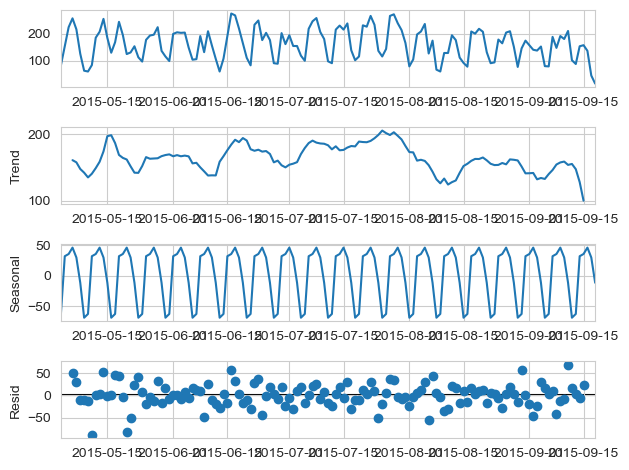

In [16]:
decomposition = seasonal_decompose(events_seasonal, model='additive') 
decomposition.plot()
plt.rcParams['figure.figsize'] = (10,11.5)
plt.show()

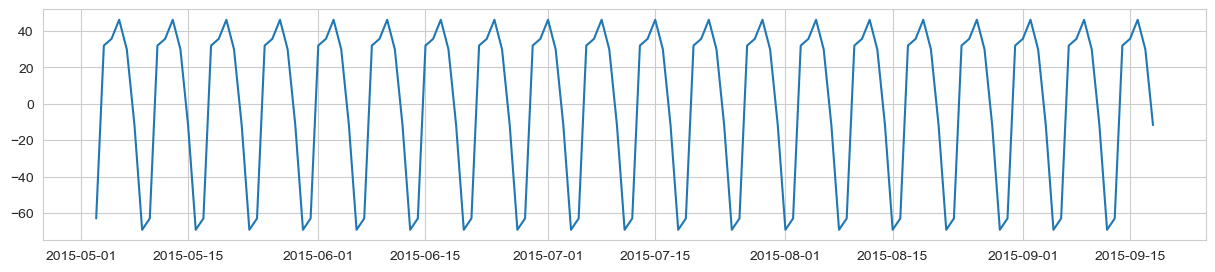

In [17]:
#decomposition.trend
fig, axis = plt.subplots(figsize = (15, 3))
plt.plot(decomposition.seasonal)

In [18]:
from statsmodels.tsa.stattools import adfuller

event_type_list = ['transaction', 'addtocart', 'view']
df = pd.DataFrame(df_events.groupby(['date'])[event_type_list].sum()).reset_index()

test = adfuller(df.set_index(['date'])['transaction'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -2.8169349116003723
p-value:  0.05589515826276706
Critical values:  {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
ряд не стационарен


Временной ряд не стационарен (имеем непостоянное среднее), также мы наблюдаем сезонность. 
</br> Т.к. наша основная цель не в построении прогнозов на основе временного ряда, а обнаружить связь записей между событиями - мы не будет дифференцировать ряд.
</br>
</br>
Проверим логарифмированные значения (чтобы уменьшить размах) по категориям.

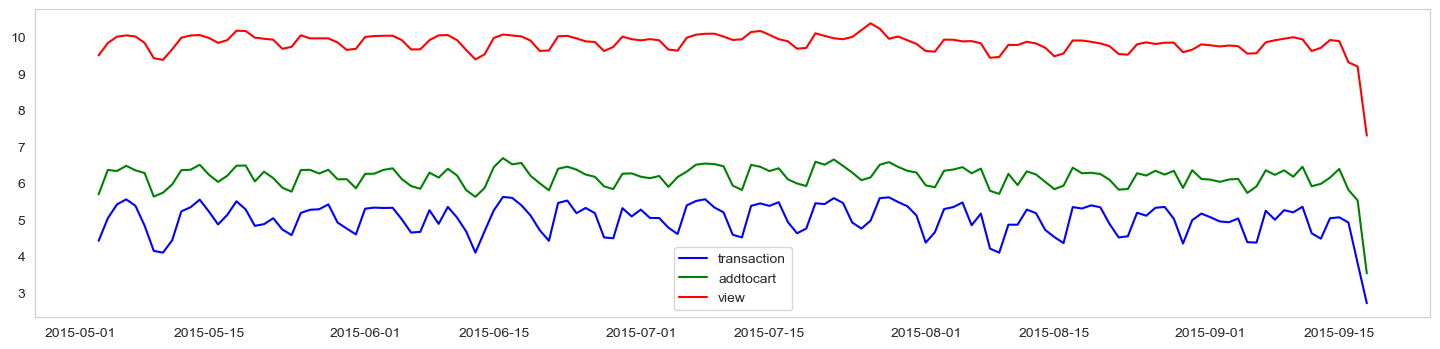

In [19]:
import matplotlib.pyplot as plt 
%matplotlib inline

color_list = ['b', 'g', 'r']

df = pd.DataFrame(df_events.groupby(['date'])[event_type_list].sum()).reset_index()

f, ax = plt.subplots(1, 1, figsize=(18, 4))
color_count = 0
for column in event_type_list:
    ## визуализируем
    ax.plot(df.date, np.log(df[column]), c = color_list[color_count]) ## исходные данные
    #ax.plot(df.date, df.view, c='r') ## оконное среднее
    #ax.plot(df.date, df.addtocart,  c='g') ## оконный максимум
    color_count += 1
    
ax.legend(event_type_list)
ax.grid()
plt.show()

Мы уже видим цепочку событий. Проверим корреляцию.

C:\Users\leoge\AppData\Local\Temp\ipykernel_1784\1878650726.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True,


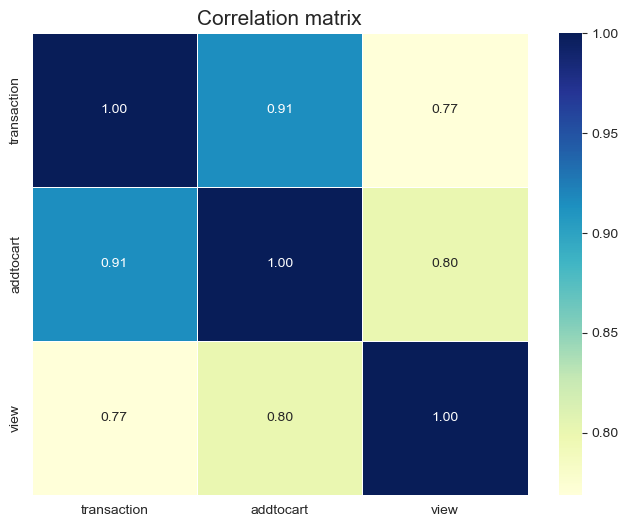

In [20]:
import seaborn as sns

#Корреляция Пирсона
plt.figure(figsize = (8, 6))
sns.heatmap(df.corr(), annot=True,
            fmt='.2f', cmap='YlGnBu', linewidth=0.5)
plt.title('Correlation matrix', size=15);

Линейная зависимость присутствует. 
</br>
Мы доказали, что цепь событий существует.
</br>
Необходимо преобразовать датасет, оставив конечное событие взаимодействия между пользователем и товаром.

<a id='analysis_time_bonus'></a>
## Дополнительная проверка: Частота

### По дням недели

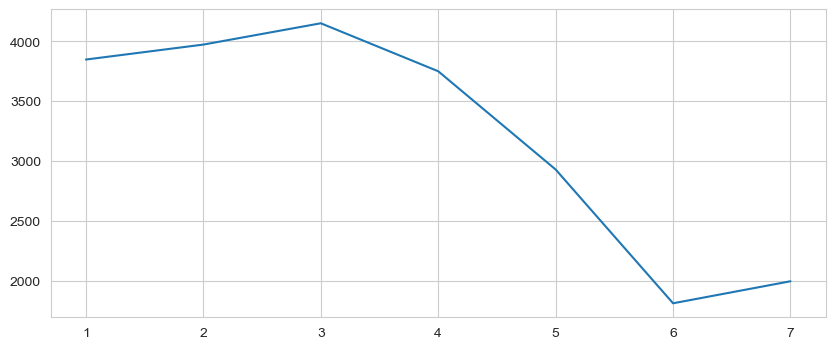

In [21]:
df['dayofweek'] = df['date'].apply(lambda x: x.isoweekday())

fig = plt.subplots(figsize = (10, 4))
plt.plot(df.sort_values(['transaction'], ascending = False).groupby(df['dayofweek'])['transaction'].sum())

Наиболее популярный день совершения покупок - среда. (Увидим далее при работе с моделью XGBoost)

### По времени суток

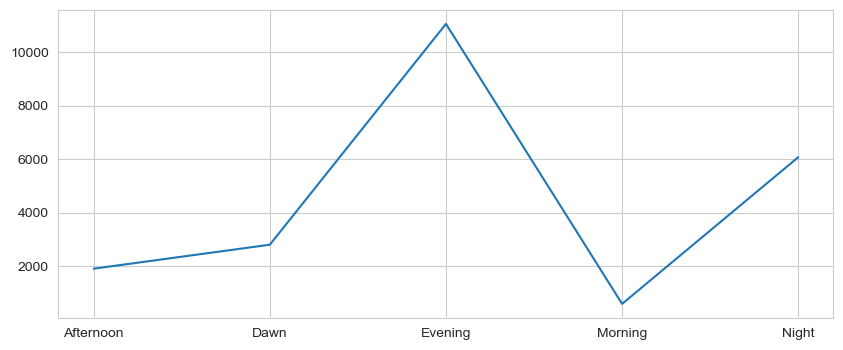

In [22]:
df_period = df_events[df_events['transaction'] == 1].groupby(['day_period'])['transaction'].sum()

fig = plt.subplots(figsize = (10, 4))
plt.plot(df_period)

Наиболее популярное время суток - вечер. (Увидим далее при работе с моделью XGBoost)

### По дням недели и времени суток

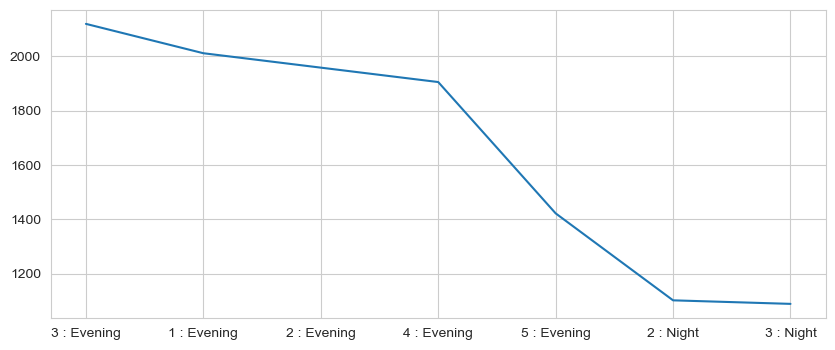

In [23]:
df_period_week = df_events[df_events['transaction'] == 1][['day_period', 'day_of_week', 'transaction']].reset_index(drop = True)
df_period_week['day_merged'] = df_period_week['day_of_week'].astype(str) + ' : ' + df_period_week['day_period'].astype(str)
df_period_week = df_period_week.groupby(['day_merged'])['transaction'].sum().sort_values(ascending = False).head(7)

fig = plt.subplots(figsize = (10, 4))
plt.plot(df_period_week)

Вечер среды самый благоприятный момент для совершений покупок (транзакций). Вечер считается наиболее популярным временем суток для пользователей, что является правдой с точки зрения поведенческой аналитики.
</br>
</br>
<b>На заметку:</b> Cоздать дополнительный алгоритм рекомендаций, срабатывающий отдельно в вечернее время суток. В качестве рекомендаций пользователям выдавались бы товары категории 2 (добавлены в коризину, но не приобретены). Проселдить динамику событий.

### Посмотрим временную дельту по событиям

Так как пользователь мог совершать событие после приобретения/добавления товара, необходимо получить время истинного конечного события.
</br><b>Пример</b>, пользователь посмотрел товар -> доабвил товар в корзину -> приобрел товар -> вновь посмотрел и добавил товар в корзину
</br>
</br>
Ориентироваться мы будем на первый просмотр товара. Тем самым мы сможем установить средний временной промежуток между первым просмотром и покупкой товара.

In [24]:
# Creating dataframes for each category
datetime_view = df_events[['visitorid', 'itemid', 'datetime']][df_events['event'] == 'view']
datetime_addtocart = df_events[['visitorid', 'itemid', 'datetime']][df_events['event'] == 'addtocart']
datetime_transaction = df_events[['visitorid', 'itemid', 'datetime']][df_events['event'] == 'transaction']

# Merge together new created dataframes
df_merged = datetime_transaction.merge(datetime_addtocart, 
                           how ='inner', 
                           on = ['itemid', 'visitorid'], 
                           suffixes=[' (transaction)', ' (addtocart)'])
df_merged = df_merged.merge(datetime_view, how='inner', on=['visitorid','itemid'])
df_merged = df_merged.rename(columns={'datetime':'datetime (view)'})

# Keep rows with the right time sequence (transaction after addtocart)
df_merged = df_merged[df_merged['datetime (transaction)'] > df_merged['datetime (addtocart)']
                     ].sort_values(['visitorid', 'itemid'])
# Keep rows with the right time sequence (addtocart after view)
df_merged = df_merged[df_merged['datetime (addtocart)'] > df_merged['datetime (view)']
                     ].sort_values(['visitorid', 'itemid','datetime (transaction)',
                                    'datetime (addtocart)', 'datetime (view)'])

# Pick the firt and last view before adding to cart
df_merged_first = df_merged.drop_duplicates(subset = ['visitorid', 'itemid'], 
                                            keep = 'first').rename(columns = {'datetime (view)':'datetime (view) first'})
df_merged_last = df_merged.drop_duplicates(subset = ['visitorid', 'itemid'], 
                                           keep = 'last').rename(columns = {'datetime (view)':'datetime (view) last'})

# Merge both dataframes together to get both columns in one dataframe
df_merged = df_merged_last.merge(df_merged_first[['itemid', 'visitorid', 'datetime (view) first']], 
                                 how = 'left', 
                                 on = ['itemid', 'visitorid'])

In [25]:
# Timedelta in minutes between datetime
columns_list = ['datetime (transaction)', 'datetime (addtocart)',
                'datetime (view) last', 'datetime (view) first']

# List of new columns that will be created
minutes_list = []

# For loop to count the difference
for index1, col1 in enumerate(columns_list):
    for index2, col2 in enumerate(columns_list):
        if index2 >  index1:
            strp_col1 = '_'.join([str(i).replace('(', '').replace(')', '') for i in col1.split()][1:])
            strp_col2 = '_'.join([str(i).replace('(', '').replace(')', '') for i in col2.split()][1:])
            strp_col = strp_col1 + '_' + strp_col2 + '_minutes'
            df_merged[''+strp_col+''] = ((df_merged[col1] - df_merged[col2]
                                              ).dt.seconds // 60)%60
            minutes_list.append(strp_col)

Чтобы не исказить представление о временном промежутке между просмотром (first и last) и транзакции - воспользуемся кванителями. Так мы отбросим дельты, являющиеся выбросами. 

In [26]:
def quantile_check(df, col):
    Q1 = np.quantile(df[col], .25)
    Q3 = np.quantile(df[col], .75)
    IQR = Q3 - Q1

    left_border = Q1 - 1.5 * IQR
    right_border = Q3 + 1.5 * IQR

    left_outers = df[df[col] < left_border]
    right_outers = df[df[col] > right_border]
    
    return left_border, right_border

value_list = ['transaction_addtocart_minutes', 'transaction_view_last_minutes', 'addtocart_view_last_minutes']

for col in minutes_list:
    if col in value_list:
        col1 = [i for i in col.split('_')][1]
        col2 = [i for i in col.split('_')][0]
        left_border, right_border = borders = quantile_check(df_merged, col)
        minutes_temp = np.round((df_merged[col][(df_merged[col] > left_border) & 
                                                (df_merged[col] < right_border)]).mean(), decimals = 0).astype(int)
        print(f'Среднее время между событиями',col1, 'и', col2, 'составляет',minutes_temp, 'минут.')

Среднее время между событиями addtocart и transaction составляет 4 минут.
Среднее время между событиями view и transaction составляет 7 минут.
Среднее время между событиями view и addtocart составляет 1 минут.


Среднее время пути пользователя от просмотра до покупки товара (по топ 10 проданных товаров) составляет 7 минут.


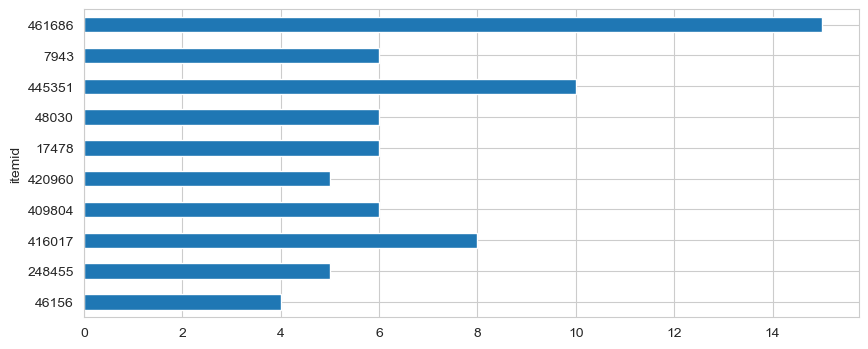

In [27]:
# Проверка топ 10 товаров. Среднее время составляет 7 минут

df_itemid_mean = pd.DataFrame(df_merged.groupby(['itemid'])[value_list].mean().reset_index())
df_itemid_count = pd.DataFrame(df_merged.groupby(['itemid'])[value_list].count().reset_index())

df_itemid = df_itemid_mean.merge(df_itemid_count[['itemid', 'transaction_addtocart_minutes']], 
                                 on = ['itemid'], 
                                 how = 'left', 
                                 suffixes = ['', '_count'])

for col in df_itemid[value_list]:
    df_itemid[col] = np.round(df_itemid[col])

top10 = df_itemid[df_itemid['transaction_addtocart_minutes_count'] > 10
                ].sort_values('transaction_addtocart_minutes_count').set_index('itemid')
top10 = pd.Series(top10['transaction_addtocart_minutes'])

fig, ax = plt.subplots(figsize = (10, 4))
top10.tail(10).plot(kind = 'barh')

print('Среднее время пути пользователя от просмотра до покупки товара (по топ 10 проданных товаров) составляет', 
      np.round(top10.tail(10).mean()).astype(int), 'минут.')

### Выводы:

- Цепь событий доказана, что означает наличие дублей для рейтинговой системы (понадобится при работе с моделями). "Повторные записи" будут удалены, останется только конечное событие.
- Средняя время пользователя от просмотра (последнего) до покупки товара составляет 7 минут.
- Обнаружено самое популярное время суток для покупки товара - вечер/ночь. Самое попоулярный день недели - среда.
- Выявлена сезонность временного ряда, что, чаще всего, означает стационнарность временного ряда - что мы доказали. К методу дифференцирования временного ряда прибигать не будем, т.к. наша модель будет ориентирована на решение проблемы рекомендаций, а не предсказаний.

[Вернуться к началу](#begin)

<a id='analysis_items'></a>
## Анализ свойств товаров

In [28]:
item_1 = pd.read_csv('3 item_properties_part1.csv')
item_2 = pd.read_csv('4 item_properties_part2.csv')

Датасеты item_properties_part1 и part2 имеют конфиденциальные данные, которые были хешированы (столбец value).
</br> Мы не можем с уверенностью сообщить назначение датасетов до анализа.

In [29]:
item_df_list = [item_1, item_2]
item_df_name = ['item_1', 'item_2']

for index, df in enumerate(item_df_list):
    print(f'Датасет: {item_df_name[index]}')

    print(f'Из {len(df)} записей, кол-во уникальных itemid составляет {len(df.itemid.unique())}.')
    

    df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms')
    df['date'] = df['datetime'].dt.date
    
    print(f'Первая и последняя даты {item_df_name[index]}: {df.date.min()} - {df.date.max()}')
    
    df = df.groupby(['itemid'])[['datetime', 'property','value']].value_counts()
    df = pd.DataFrame(df).reset_index().drop(columns = [0])
    df['date'] = df['datetime'].dt.date
    
    display(df.head(10))

Датасет: item_1
Из 10999999 записей, кол-во уникальных itemid составляет 417053.
Первая и последняя даты item_1: 2015-05-10 - 2015-09-13


,itemid,datetime,property,value,date
0,0,2015-05-10 03:00:00,159,519769,2015-05-10
1,0,2015-05-10 03:00:00,283,66094 372274 478989,2015-05-10
2,0,2015-07-12 03:00:00,6,1152934 1238769,2015-07-12
3,0,2015-07-26 03:00:00,6,1152934 1238769,2015-07-26
4,0,2015-08-02 03:00:00,6,1152934 1238769,2015-08-02
5,0,2015-08-09 03:00:00,6,1152934 1238769,2015-08-09
6,0,2015-08-16 03:00:00,6,1152934 1238769,2015-08-16
7,0,2015-08-23 03:00:00,6,1152934 1238769,2015-08-23
8,0,2015-08-30 03:00:00,6,1152934 1238769,2015-08-30
9,0,2015-09-06 03:00:00,6,66094,2015-09-06


Датасет: item_2
Из 9275903 записей, кол-во уникальных itemid составляет 417053.
Первая и последняя даты item_2: 2015-05-10 - 2015-09-13


,itemid,datetime,property,value,date
0,0,2015-05-10 03:00:00,790,n91200.000,2015-05-10
1,0,2015-05-10 03:00:00,categoryid,209,2015-05-10
2,0,2015-05-31 03:00:00,764,1285872,2015-05-31
3,0,2015-05-17 03:00:00,698,1152934 1238769,2015-05-17
4,0,2015-05-24 03:00:00,139,n4800.000 270060 924073,2015-05-24
5,0,2015-05-24 03:00:00,202,478989,2015-05-24
6,0,2015-05-24 03:00:00,839,372274,2015-05-24
7,0,2015-05-31 03:00:00,127,1168476,2015-05-31
8,0,2015-05-31 03:00:00,561,1294803 101489,2015-05-31
9,0,2015-05-31 03:00:00,869,769062,2015-05-31


Записи периодически обновляются и на один itemid может приходится несколько обновлений, которые связаны со сменой значений столбцов и/или добавлением новых значений в столбцы property и value.
</br>
</br>
Наличие строковых значений в столбце обеспечило бы возможность использовать рекомендации по текстовому описанию. Но в данной задаче мы ограничены только событиями, а значит и модели будут использовать скрытую факторизацию.
</br>
</br>
Как было опсиано выше, некоторые записи - это присвоение property товару, в том числе, повторное присвоение. Возможно, есть взаимосвязь между кол-вом обновлений и продаваемости товаров. Убедимся в наличии дублей.

In [30]:
# df_events
df_events[(df_events['itemid'] == 355908) & (df_events['visitorid'] == 257597)]

# item_1
item_1[(item_1['itemid'] == 355908
              ) & (item_1['date'] > datetime.datetime.strptime('15-06-01', '%y-%m-%d').date()
                  ) & (item_1['date'] < datetime.datetime.strptime('15-06-10', '%y-%m-%d').date()
                      )].sort_values('datetime')

,timestamp,itemid,property,value,datetime,date
3461176,1433646000000,355908,1036,726612,2015-06-07 03:00:00,2015-06-07
4012974,1433646000000,355908,364,610075,2015-06-07 03:00:00,2015-06-07
6431872,1433646000000,355908,400,n600.000 424566,2015-06-07 03:00:00,2015-06-07
6653206,1433646000000,355908,1066,n1020.000 424566,2015-06-07 03:00:00,2015-06-07
7147329,1433646000000,355908,566,n726.000 424566,2015-06-07 03:00:00,2015-06-07
9344903,1433646000000,355908,790,n89280.000,2015-06-07 03:00:00,2015-06-07
9544379,1433646000000,355908,698,283006 812080,2015-06-07 03:00:00,2015-06-07


Объеденим оба датасета в один.

In [31]:
df_item = item_1.append(item_2)

C:\Users\leoge\AppData\Local\Temp\ipykernel_1784\653339447.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_item = item_1.append(item_2)


Чтобы не вознкли проблемы с работоспособностью - сразу удалим item_properties_part1 и item_properties_part2 из временной памяти ноутбука.

In [32]:
del item_1
del item_2

Сейчас мы можем посчитать количество обновлений, количество уникальных свойств и количество значений на товар.

In [33]:
# Counting number of updates for each itemid
item_update = pd.DataFrame(df_item.groupby(['itemid']
                                           )['datetime'].count()
                            ).reset_index().rename(columns = {'datetime':'update_count'})

# Counting number of unique property values for each itemid
item_unique_property = df_item.drop_duplicates(['itemid', 'property']).groupby(['itemid'])['property'].value_counts()
item_unique_property = pd.DataFrame(item_unique_property
                                     ).rename(columns = {'property':'property_count'}
                                             ).reset_index().drop('property', axis = 1)
item_unique_property = pd.DataFrame(item_unique_property.groupby(['itemid'])['property_count'].sum()).reset_index()

# Counting number of unique "value" for each itemid
item_unique_value = df_item.drop_duplicates(['itemid', 'value']).groupby(['itemid'])['value'].value_counts()
item_unique_value = pd.DataFrame(item_unique_value
                                     ).rename(columns = {'value':'value_count'}
                                             ).reset_index().drop('value', axis = 1)
item_unique_value = pd.DataFrame(item_unique_value.groupby(['itemid'])['value_count'].sum()).reset_index()

# Merge all three dataframes together
item_merged = item_update.merge(item_unique_property, on = 'itemid', how = 'left'
                                   ).merge(item_unique_value, on = 'itemid', how = 'left')

item_merged.sort_values('update_count').tail(5)

,itemid,update_count,property_count,value_count
107623,120386,444,53,50
134798,150800,459,51,44
82119,91855,461,53,53
226996,254069,462,54,55
142045,158903,468,55,45


Есть товары, где на множество property приходится меньшее кол-во value, значит одинаковое value может принадлежат нескольким property.

In [34]:
property_count = pd.DataFrame(df_item.drop_duplicates(['itemid', 'property', 'value']
                                                     ).groupby(['property'])['value'].count()
                             ).reset_index()
property_count.head(5)

,property,value
0,0,12696
1,1,5649
2,10,468
3,100,209
4,1000,2838


Проверим предположение, которое описал выше - больше свойств/категорий на товар - больше продаж.

In [35]:
popular_transaction = events[events['event'] == 'transaction']
popular_transaction = popular_transaction.groupby('itemid')['event'].value_counts().sort_values().tail(5)
popular_transaction = pd.DataFrame(popular_transaction).rename(columns = {'event':'event_count'}
                                                              ).reset_index().drop('event', axis = 1)
popular_transaction_merged = popular_transaction.merge(item_merged, on = 'itemid', how = 'left')

popular_property = item_merged.sort_values('property_count').tail(5)

popular_transaction_merged[popular_transaction_merged['itemid'].isin(popular_property['itemid'])]

,itemid,event_count,update_count,property_count,value_count


Топ 5 проданных товаров не входят в Топ 5 по кол-ву свойств. 

<a id='save_events'></a>
## Сохранение: Dataset df_events

In [36]:
df_events.to_csv('df_events.csv', sep = ';')

### Выводы:

- Мало информации о истинной природы свойств товаров. При расширении доступа возможна генерация рекомендаций на основе текстового описания.
- Возможное совпадение по категориям, что дает преимущство при разработки стратегии холодного старта - рекомендации по максимальному совпадению категорий.

[Вернуться к началу](#begin)

<a id='create_factors'></a>
# Создание факторов для модели

<a id='preprocessing_rating'></a>
## Dataset: df_temp

С некоторыми моделями могут возникнуть проблемы масштабируемости. Сократим данные оставив только конечную цель взаимодействия между пользователем и товаром: Если товар бы приобретен и добавлен в корзину после приобретения (возможная ф-ия "Купить в один клик" или срез по добавлении ранее и т.д.), то считаем конечную цель - приобретение.

### Предобработка: Получение конечного события с группировкой по пользователю и товару

In [37]:
df_temp = pd.DataFrame(df_events.groupby(['visitorid', 'itemid', 'event'])['timestamp'].max().sort_values()).reset_index()
df_temp['event_count'] = df_temp['event'].apply(lambda x: 1.0 if str(x) == 'view' else (2.0 if str(x) == 'addtocart' else 3.0))

display(df_temp[(df_temp['visitorid'] == 152963) & (df_temp['itemid'] == 21970)])
display(df_temp[(df_temp['visitorid'] == 435495) & (df_temp['itemid'] == 175893)])

,visitorid,itemid,event,timestamp,event_count
2215275,152963,21970,addtocart,1442544102108,2.0
2215282,152963,21970,transaction,1442544192017,3.0
2215289,152963,21970,view,1442544216329,1.0


,visitorid,itemid,event,timestamp,event_count
772,435495,175893,view,1430625420342,1.0
846,435495,175893,addtocart,1430625831436,2.0
897,435495,175893,transaction,1430626058961,3.0


Как мы видим на примере двух пользователей, не только это цепь событий, но и с возможными аномлиями - посмотрел товар до добавления и приобретения.

Чтобы избежать этого и получить конечную цель товара по пользователю - сделаем группировку с результатом последнего события.

In [38]:
df_temp = df_temp.sort_values('event_count').groupby(['visitorid', 'itemid']).tail(1).reset_index().drop(columns = ['index'])

display(df_temp[(df_temp['visitorid'] == 152963) & (df_temp['itemid'] == 21970)])
display(df_temp[(df_temp['visitorid'] == 435495) & (df_temp['itemid'] == 175893)])

,visitorid,itemid,event,timestamp,event_count
2124309,152963,21970,transaction,1442544192017,3.0


,visitorid,itemid,event,timestamp,event_count
2125780,435495,175893,transaction,1430626058961,3.0


<a id='save_temp'></a>
## Сохранение: Dataset df_temp

In [39]:
df_temp.to_csv('df_temp.csv', sep = ';')

<a id='xgboost_preprocessing'></a>
# Дополнительные признаки: df_temp_features

Поскольку работа с градиентным бустингом и XGBoost подразуемвают использование факторов, то нам необходимо создать необходимые нам признаки. Наилучшим решением будет продолжить использовать df_temp, т.к. конечный объем данных будет слишком большим.

### Features: Временные признаки

In [41]:
# Copy original dataset
df_temp_features = df_temp.copy()

# Transform timestamp to datetime
df_temp_features['datetime'] = pd.to_datetime(df_temp_features['timestamp'], unit='ms')
df_temp_features['date'] = df_temp_features['datetime'].dt.date
df_temp_features['day_of_week'] = df_temp_features['datetime'].map(lambda x: x.weekday() + 1)

df_temp_features['year'] = df_temp_features['datetime'].map(lambda x: x.year)
df_temp_features['month'] = df_temp_features['datetime'].map(lambda x: x.month)
df_temp_features['day'] = df_temp_features['datetime'].map(lambda x: x.day)
df_temp_features['hour'] = df_temp_features['datetime'].map(lambda x: x.hour)
df_temp_features['minute'] = df_temp_features['datetime'].map(lambda x: x.minute)

def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
df_temp_features['day_period'] = df_temp_features['hour'].map(get_time_periods)
df_temp_features['day_period'].value_counts()

Evening      833238
Night        596404
Dawn         388269
Afternoon    227875
Morning       99393
Name: day_period, dtype: int64

In [42]:
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_array = encoder.fit_transform(df_temp_features[['day_of_week']]).toarray()
feature_labels = np.array(encoder.categories_).ravel()
feature_labels = list(feature_labels)

count = 0
for i in feature_labels:
    feature_labels[count] = 'day_of_week_' + str(i)
    count+=1

encoder_df = pd.DataFrame(encoder_array, columns = feature_labels).reset_index(drop = True)
df_temp_features = df_temp_features.reset_index(drop = True)
df_temp_features = df_temp_features.join(encoder_df)

#df_temp_features.drop(columns = ['day_of_week'], axis = 0, inplace = True)

In [44]:
item_merged = df_item.copy()

del df_item

### Features: ParentID

In [45]:
import re

# Timestamp -> Datetime
item_merged['datetime'] = pd.to_datetime(item_merged['timestamp'], unit = 'ms')

In [46]:
#find_string = re.compile('[a-zA-Z]+') # String pattern
find_number = re.compile('[0-9]') # Number pattern

unique_property = list(set(item_merged['property']))

unique_char = set()
for i in unique_property:
    temp = re.sub(find_number, ' ', str(i))
    unique_char.add(temp)
    
# Delete rows containing string properties
item_merged = item_merged[~item_merged['property'].isin(unique_char)]

# Groupby itemid & property
item_merged = pd.DataFrame(item_merged.groupby(['itemid', 'property'])['datetime'].max().sort_values()).reset_index()

# Leave only last 3 updates
item_merged = item_merged.sort_values('datetime').groupby('itemid').tail(3)

# Change column type
item_merged['property'] = item_merged['property'].astype(int)

# Rename column
category_tree = category_tree.rename(columns = {'categoryid':'property'})

# Merge together
df_item_merged = pd.merge(item_merged, category_tree, on = 'property', how = 'left')

# Dropna in parentid column
df_item_merged = df_item_merged.dropna(subset = ['parentid'])

# Change column type
df_item_merged['parentid'] = df_item_merged['parentid'].astype(int)

# Create unique list of parentid's
parentid_list = sorted(list(df_item_merged['parentid'].unique()))



# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_array = encoder.fit_transform(df_item_merged[['parentid']]).toarray()
feature_labels = np.array(encoder.categories_).ravel()
feature_labels = list(feature_labels)

encoder_df = pd.DataFrame(encoder_array, columns = feature_labels).reset_index(drop = True)
df_item_merged = df_item_merged.reset_index(drop = True)
df_item_merged = df_item_merged.join(encoder_df)

# Sum all features together
df_item_merged = pd.DataFrame(df_item_merged.groupby('itemid')[parentid_list].sum()).reset_index()

# Append all columns
df_columns = []

for col in df_item_merged.columns:
    temp = str(col).replace(' ', '')
    df_columns.append(temp)
    
# Change columns
df_item_merged.columns = df_columns

### Features: Время суток

In [47]:
# OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_array = encoder.fit_transform(df_temp_features[['day_period']]).toarray()
feature_labels = np.array(encoder.categories_).ravel()

encoder_df = pd.DataFrame(encoder_array, columns = feature_labels).reset_index(drop = True)
df_temp_features = df_temp_features.reset_index(drop = True)
df_temp_features = df_temp_features.join(encoder_df)

# Delete unnecessary column
df_temp_features.drop(columns = ['day_period'], inplace = True)

### Features: События до

In [48]:
# IMPORT
df_events = pd.read_csv('df_events.csv', sep = ';').drop(columns = ['Unnamed: 0'])

# Create DF of events sum
df_features = pd.DataFrame(df_events.groupby(['visitorid', 'itemid'])[['view',  'addtocart', 'transaction'
                                                                      ]].sum()).reset_index()
df_features = df_features.sort_values(['visitorid', 'itemid'])

df_features = df_features.rename(columns = {'view':'view_before', 'addtocart':'addtocart_before'})

columns_list = ['view', 'addtocart']

for col in columns_list:
    df_features[''+col+'_before_1'] = df_features[''+col+'_before'].apply(lambda x: 1 if x > 0 else 0)
    df_features[''+col+'_before_5'] = df_features[''+col+'_before'].apply(lambda x: 1 if x >= 5 else 0)
    df_features[''+col+'_before_10'] = df_features[''+col+'_before'].apply(lambda x: 1 if x >= 10 else 0)
    df_features[''+col+'_before_50'] = df_features[''+col+'_before'].apply(lambda x: 1 if x >= 50 else 0)

    df_features[''+col+'_before_count'] = df_features[''+col+'_before_50'] \
    + df_features[''+col+'_before_10'] \
    + df_features[''+col+'_before_5'] \
    + df_features[''+col+'_before_1']

    df_features[''+col+'_before'] = df_features[''+col+'_before_count'].apply(lambda x: ''+col+'_before_1' if x == 1 else 
                                                              (''+col+'_before_5' if x == 2 else 
                                                               (''+col+'_before_10' if x == 3 else 
                                                                (''+col+'_before_50' if x == 4 else ''+col+'_before_0'))))

    df_features.drop(columns = [''+col+'_before_50', ''+col+'_before_5', ''+col+'_before_1', 
                        ''+col+'_before_10', ''+col+'_before_count'], inplace = True)
    
# Transaction - if value equals 0 or 1 - NO transaction BEFORE
df_features['transaction_before'] = df_features['transaction'].apply(
    lambda x: 'transaction_before_1' if x > 1 else 'transaction_before_0')
df_features = df_features.drop(columns = ['transaction'])

In [49]:
# OneHotEncoder
ohe_columns = ['view_before', 'addtocart_before', 'transaction_before']

for col in ohe_columns:
    # OneHotEncoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_array = encoder.fit_transform(df_features[[col]]).toarray()
    feature_labels = np.array(encoder.categories_).ravel()

    encoder_df = pd.DataFrame(encoder_array, columns = feature_labels).reset_index(drop = True)
    df_features = df_features.reset_index(drop = True)
    df_features = df_features.join(encoder_df)

    # Delete unnecessary column
    df_features.drop(columns = [col], inplace = True)

In [50]:
# Create transaction for temp
df_temp['transaction'] = df_temp['event'].apply(lambda x: 1 if x == 'transaction' else 0)

# Apply transaction to df_features from df_temp
df_features = pd.merge(df_features, df_temp[['visitorid', 'itemid', 'transaction']], on = ['visitorid', 'itemid'], how = 'left')

<a id='save_all_features_light'></a>
## Сохранение: Dataset df_all_features_light

In [51]:
# Merge BEFORE features DF & Item Merged DF
df_all_features_light = pd.merge(df_temp_features, df_features, on = ['visitorid', 'itemid'], how = 'left')

In [ ]:
df_all_features_light.to_csv('df_all_features_light.csv', sep = ';')

<a id='save_all_features'></a>
## Сохранение: Dataset df_all_features

Внимание! Большой объем выходного файла.

In [1]:
# # Merge BEFORE features DF & Item Merged DF
# df_item_features = pd.merge(df_features, df_item_merged, on = 'itemid', how = 'left')

# # Merge All features DF & Item Merged DF
# df_all_features = pd.merge(df_temp_features, df_item_features, on = ['visitorid', 'itemid'], how = 'left')

# df_all_features.to_csv('df_all_features.csv', sep = ';')

<a id='end'></a>
# Заключение на стадии анализа и предобработки:

- Обработан основной датасет событий, который сформирован под рекомендательные модели.
- Выявлены значимые признаки для предсказаний со стороны модели (отдельное семейство среди моделей GradientBoost и XGBoost), добавлены новые признаки.
- Итоговое кол-во выгрузок составляет 4 датасета, для проведения экспериментов.

[Вернуться к началу](#begin)